In [1]:
#数据路径设置
import os
import sys
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

import numpy as np
import cv2
import matplotlib.pyplot as plt
DATA_DIR = '..\camvid' # 根据自己的路径来设置

x_train_dir = os.path.join(DATA_DIR, 'train_images')
y_train_dir = os.path.join(DATA_DIR, 'train_labels')

x_valid_dir = os.path.join(DATA_DIR, 'valid_images')
y_valid_dir = os.path.join(DATA_DIR, 'valid_labels')

x_test_dir = os.path.join(DATA_DIR, 'test_images')
y_test_dir = os.path.join(DATA_DIR, 'test_labels')

print(x_train_dir, y_train_dir, x_valid_dir, y_valid_dir, x_test_dir, y_test_dir)

..\camvid\train_images ..\camvid\train_labels ..\camvid\valid_images ..\camvid\valid_labels ..\camvid\test_images ..\camvid\test_labels


In [2]:
#数据加载类，用于训练、验证、测试时提供数据加载支持
import torch
import random
from torch.utils.data import DataLoader
from torch.utils.data import Dataset as BaseDataset

class Dataset(BaseDataset):
    """CamVid Dataset. Read images, apply augmentation and preprocessing transformations.
    
    Args:
        images_dir (str): path to images folder
        masks_dir (str): path to segmentation masks folder
        class_values (list): values of classes to extract from segmentation mask
        augmentation (albumentations.Compose): data transfromation pipeline 
            (e.g. flip, scale, etc.)
        preprocessing (albumentations.Compose): data preprocessing 
            (e.g. noralization, shape manipulation, etc.)
    
    """
    CLASSES = ['animal', 'archway', 'bicyclist', 'bridge', 'building', 'car', 'cartluggagepram',
               'child', 'column_pole', 'fence', 'lanemkgsdriv', 'lanemkgsnondriv',
               'misc_text', 'motorcyclescooter', 'othermoving', 'parkingblock', 'pedestrian',
               'road', 'roadshoulder', 'sidewalk', 'signsymbol', 'sky', 'suvpickuptruck',
               'trafficcone', 'trafficlight', 'train', 'tree', 'truck_bus', 'tunnel', 'vegetationmisc', 
               'void', 'wall']
    def __init__(
            self, 
            images_dir, 
            masks_dir, 
            classes=None,
            augmentation=None,
    ):
        self.ids = os.listdir(images_dir)
        self.images_fps = [os.path.join(images_dir, image_id) for image_id in self.ids]
        self.masks_fps = [os.path.join(masks_dir, image_id) for image_id in self.ids]
        self.class_values = [self.CLASSES.index(cls.lower()) for cls in classes]
        '''for content in self.class_values:
            print('self.class_values:', content)'''
        
        self.augmentation = augmentation

    
    def __getitem__(self, i):
                
        # read data
        #print("ids: %d" % i)
        #由于anaconda会在各个目录添加.ipynb_check...的文件，当当前读取的文件名称不是png文件时,重新随机读取文件
        while self.images_fps[i][-4:] != '.png':
            #print('%s is not a png file!' % self.images_fps[i])
            i = random.randint(0,len(self.ids) - 1)
            #print('try to use file %s.' % self.images_fps[i])
        if self.images_fps[i].split('\\')[-1] != self.images_fps[i].split('\\')[-1]:
            print('error: label:%s is not match to images:%s' % (self.images_fps[i].split('\\')[-1], self.images_fps[i].split('\\')[-1]))
            os._exit() 
        #print(self.images_fps[i])
        #print(self.masks_fps[i])
        image = cv2.imread(self.images_fps[i])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.masks_fps[i], 0)
        
        #多分类
        masks = [(mask == v) for v in self.class_values]
        mask = np.stack(masks, axis=-1).astype('float')
        
        # add background if mask is not binary
        if mask.shape[-1] != 1:
            background = 1 - mask.sum(axis=-1, keepdims=True)
            mask = np.concatenate((mask, background), axis=-1)
        
        #为进行二分类，此处将label文件调整为只有road与背景的图片
        #mask = (mask==90)
        #mask = (mask==17)
        #mask = mask.astype('float')  
        #plt.imshow(mask)
        # apply augmentations
        if self.augmentation:
            sample = self.augmentation(image=image, mask=mask)
            image, mask = sample['image'], sample['mask']
        return image, mask
        #return image, mask.reshape(len(self.class_values) + 1, 360, 480)
        
    def __len__(self):
        return len(self.ids)

0 255
491
imageshape: (360, 480, 3) maskshape: (360, 480, 3)


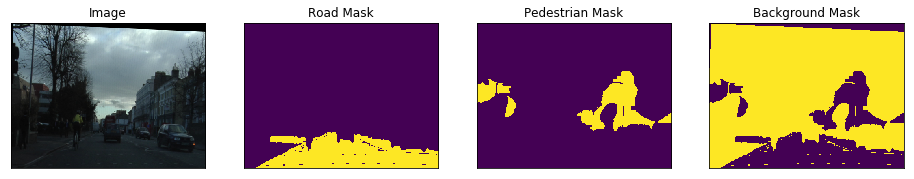

0 255
491
imageshape: (360, 480, 3) maskshape: (360, 480, 3)


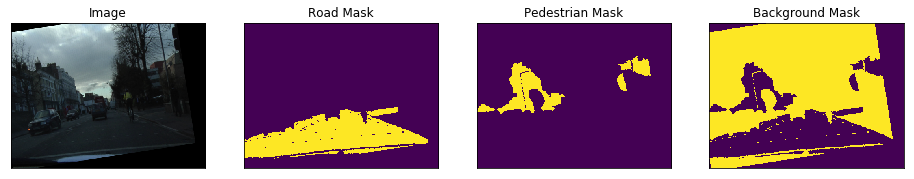

In [3]:
#### 定义图像增强函数以及图片展示函数
import albumentations as albu

def get_training_augmentation():
    train_transform = [
        albu.HorizontalFlip(p=0.5),
        albu.Resize(height=360, width=480, always_apply=True),
        albu.ShiftScaleRotate(scale_limit=0.1, rotate_limit=20, shift_limit=0.1, p=1, border_mode=0),
    ]
    return albu.Compose(train_transform)

def get_test_augmentation():
    train_transform = [
        albu.Resize(height=360, width=480, always_apply=True),
    ]
    return albu.Compose(train_transform)       

def get_val_augmentation():
    train_transform = [
        albu.Resize(height=360, width=480, always_apply=True),
    ]
    return albu.Compose(train_transform)  

augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=['Road', 'building'],
    augmentation=get_training_augmentation(), 
)

def visualize(**images):
    """PLot images in one row."""
    n = len(images)
    plt.figure(figsize=(16, 5))
    for i, (name, image) in enumerate(images.items()):
        plt.subplot(1, n, i + 1)
        plt.xticks([])
        plt.yticks([])
        plt.title(' '.join(name.split('_')).title())
        plt.imshow(image)
    plt.show()

# same image with different random transforms
for i in range(2):
    image, mask = augmented_dataset[16]
    print(np.min(image),np.max(image))
    print(len(augmented_dataset))
    print('imageshape:', image.shape, 'maskshape:', mask.shape)
    visualize(image=image, 
              road_mask=mask[..., 0].squeeze(),
              pedestrian_mask=mask[..., 1].squeeze(),
              background_mask=mask[..., 2].squeeze()
             )

In [4]:
#构建训练、验证数据集
CLASSES = ['Road', 'Car', 'Building', 'sky', 'tree', 'sidewalk', 'Pedestrian']
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    classes=CLASSES,
    augmentation=get_training_augmentation(), 
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    classes=CLASSES,
    augmentation=get_val_augmentation(), 
)

train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)

n_classes = 1 if len(CLASSES) == 1 else (len(CLASSES) + 1) 

In [5]:
#UNeth模型各模块搭建
import torch.nn as nn
import torch.nn.functional as F
from torch import optim

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        return self.double_conv(x)


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up = nn.ConvTranspose2d(in_channels // 2, in_channels // 2, kernel_size=2, stride=2)

        self.conv = DoubleConv(in_channels, out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = torch.tensor([x2.size()[2] - x1.size()[2]])
        diffX = torch.tensor([x2.size()[3] - x1.size()[3]])

        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        return self.conv(x)


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)

In [6]:
#UNet模型构建
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes, bilinear=True):
        super(UNet, self).__init__()
        self.n_channels = n_channels
        self.n_classes = n_classes
        self.bilinear = bilinear

        self.inc = DoubleConv(n_channels, 32)
        self.down1 = Down(32, 64)
        self.down2 = Down(64, 128)
        self.down3 = Down(128, 256)
        self.down4 = Down(256, 256)
        self.up1 = Up(512, 128, bilinear)
        self.up2 = Up(256, 64, bilinear)
        self.up3 = Up(128, 32, bilinear)
        self.up4 = Up(64, 32, bilinear)
        self.outc = OutConv(32, n_classes)
        if n_classes == 1:
            self.out  = torch.sigmoid
    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        logits = self.outc(x)
        if n_classes == 1:
            logits = self.out(logits)
        return logits

In [7]:
#UNet module
net = UNet(n_channels=3, n_classes=n_classes)

In [8]:
print(net)

UNet(
  (inc): DoubleConv(
    (double_conv): Sequential(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
      (3): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (4): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (5): ReLU(inplace=True)
    )
  )
  (down1): Down(
    (maxpool_conv): Sequential(
      (0): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
      (1): DoubleConv(
        (double_conv): Sequential(
          (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
          (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (4): BatchNorm2d(64, eps=1e-05, momentum=0.

Road
0.0 1.0


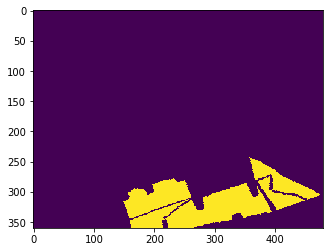

Car
0.0 1.0


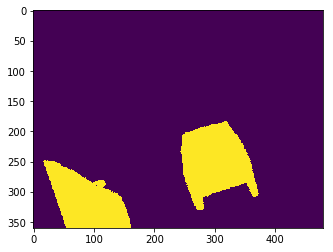

Building
0.0 1.0


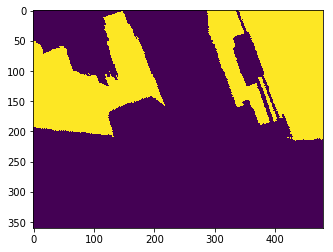

sky
0.0 1.0


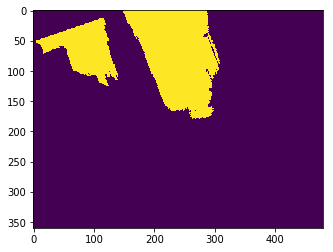

tree
0.0 1.0


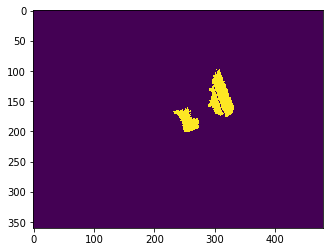

sidewalk
0.0 1.0


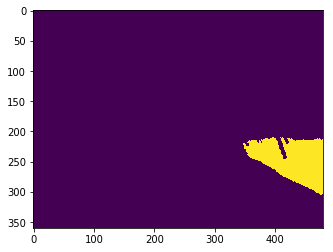

Pedestrian
0.0 1.0


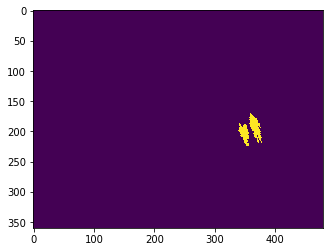

pred.shape: torch.Size([1, 8, 360, 480])
-10.313507 8.082086


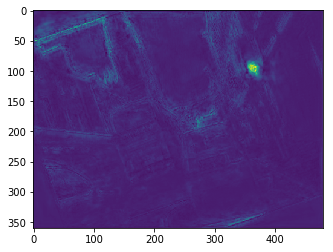

In [8]:
#数据集类别提取以及展示
image, mask = train_dataset[1]
with torch.no_grad():
    net.to('cuda')
    image = image/255.
    image = image.astype('float32')
    image = torch.from_numpy(image)
    image = image.permute(2,0,1)
    image = image.to()
    
    pred = net(image.unsqueeze(0).cuda())
    pred = pred.cpu()
for cnt in range(len(CLASSES)):
    print(CLASSES[cnt])
    plt.figure('mask')
    #print('mask.shape', mask.shape)
    #print('mask:', mask[..., 0])
    print(np.min(mask),np.max(mask))
    #plt.imshow(mask[0,:,:])
    plt.imshow(mask[..., cnt].squeeze())
    plt.show()

plt.figure('pred')
#pred = pred > 0.5
print('pred.shape:', pred.shape)
print(np.min(pred.numpy()),np.max(pred.numpy()))
plt.imshow(pred[0,0,:,:])
plt.show()

In [9]:
#对预测结果进行mIoU计算
import torch
import numpy as np
def Iou(input,target,classNum):
    '''
    :param input: [b,h,w]
    :param target: [b,h,w]
    :param classNum: scalar
    :return:
    '''
    inputTmp = torch.zeros([input.shape[0],classNum,input.shape[1],input.shape[2]])#创建[b,c,h,w]大小的0矩阵
    targetTmp = torch.zeros([target.shape[0],classNum,target.shape[1],target.shape[2]])#同上
    input = input.unsqueeze(1)#将input维度扩充为[b,1,h,w]
    target = target.unsqueeze(1)#同上
    
    inputOht = inputTmp.scatter_(index=input,dim=1,value=1)#input作为索引，将0矩阵转换为onehot矩阵
    targetOht = targetTmp.scatter_(index=target,dim=1,value=1)#同上
    batchMious = []#为该batch中每张图像存储一个miou
    total_miou = 0.
    #print('in iou \n inputOht:', inputOht.shape, '\n targetOht:', targetOht.shape)
    mul = inputOht * targetOht#乘法计算后，其中1的个数为intersection
    for i in range(input.shape[0]):#遍历图像
        ious = []
        for j in range(classNum):#遍历类别，包括背景
            intersection = torch.sum(mul[i][j])
            union = torch.sum(inputOht[i][j]) + torch.sum(targetOht[i][j]) - intersection + 1e-6
            iou = intersection / union
            ious.append(iou)
        miou = np.mean(ious)#计算该图像的miou
        #batchMious.append(miou)
        total_miou += miou
    return total_miou / input.shape[0]

In [10]:
#评估模型在验证集上的mIoU
import torch
import torch.nn.functional as F
#from tqdm import tqdm


def eval_net(net, loader, device):
    """return mIoU in the module of valid_data """
    net.eval()
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    #mask_type = torch.float32
    n_val = len(loader)  # the number of batch
    tot = 0
    mIoU = 0
    cnt = 0

    for image, label in loader:
        with torch.no_grad():
            image = image.permute(0,3,1,2)
            image = image.to(device=device, dtype=torch.float32)
            image = image/255
            mask = label.to(device=device, dtype=mask_type)
            #print('image:', image.shape, '\n', image)
            
            pred = net(image)
        #print('pred.shape:', pred.shape, pred)
        if net.n_classes > 1:
            mask = torch.topk(mask, 1)[1].squeeze(1)
            #print('in eval \n  mask:',mask.shape, mask)
            mask = mask[..., 0].cpu()
            
            pred = pred.permute(0, 2, 3, 1)
            pred = torch.topk(pred, 1)[1].squeeze(1)
            #print('in eval \n  pred:',pred.shape, pred)
            pred = pred[..., 0].cpu()
            #pred = pred.permute(2, 0, 1).cpu()
            
            miou = Iou(mask, pred, net.n_classes)
            cnt += 1
            print('cnt: %d miou : %f' % (cnt, miou), end='\r')
            sys.stdout.flush()
            tot += miou
        else:
            pred = torch.sigmoid(mask_pred)
            pred = (pred > 0.5).float()
            tot += dice_coeff(pred, true_masks).item()
    return tot / cnt

In [12]:
#测试mIoU计算函数可用性
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
mIoU = eval_net(net, valid_loader, device)
print(mIoU)

0.007615613402072406263


In [11]:
#函数测试
def eval_net_test(net, loader, device):
    """Evaluation without the densecrf with the dice coefficient"""
    net.eval()
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    #mask_type = torch.float32
    n_val = len(loader)  # the number of batch
    tot = 0
    acc = 0
    mIoU = 0
    image, label = valid_dataset[0]
    show_image = image
    
    with torch.no_grad():
        image = image/255.
        image = image.astype('float32')
        image = torch.from_numpy(image)
        image = image.permute(2,0,1)
        image = image.to()
        print('image:', image.shape, '\n', image)
        pred = net(image.unsqueeze(0).cuda())
    #print('pred.shape:', pred.shape, pred)
    show_mask = label
    show_pred = pred.permute(2, 3, 1, 0)[..., 0].cpu()
    #print('show_image:', show_image.shape, '\n show_mask:', show_mask.shape, '\n show_pred:', show_pred.shape)
    visualize(image=show_image, Mask=show_mask, Pred=show_pred)
    mask = torch.tensor(label)
    
    mask = torch.topk(mask, 1)[1].squeeze(1)
    pred = pred.permute(2, 3, 1, 0)
    pred = torch.topk(pred[..., 0], 1)[1].squeeze(1)
    
    mask = mask.permute(2, 0, 1).cpu()
    pred = pred.permute(2, 0, 1).cpu()

    #print('in eval \n pred:',pred.shape, pred)
    mIoU = Iou(mask, pred, net.n_classes)
    return mIoU

In [12]:
#在验证集上进行loss计算
def eval_val_loss(net, loader, device):
    criterion = nn.CrossEntropyLoss()
    net.eval()
    mask_type = torch.float32 if net.n_classes == 1 else torch.long
    #mask_type = torch.float32
    n_val = len(loader)  # the number of batch
    tot = 0.
    cnt = 0
    
    for data in loader:
        with torch.no_grad():
            images,labels = data
            images = images.permute(0, 3, 1, 2)
            images = Variable(images.to(device=device, dtype=torch.float32))
            images = images/255.
            mask_type = torch.float32 if net.n_classes == 1 else torch.long
            labels = Variable(labels.to(device=device, dtype=mask_type))
            pred = net(images)
            
            labels = torch.topk(labels, 1)[1].squeeze(1)
            labels = labels[:, :, :, 0]
            #print('cnt:', cnt, 'predshape:',pred.shape， pred, 'labelshape:', labels.shape, labels)
            loss = criterion(pred, labels)
            print('val-cnt-%d-loss: %f' % (cnt, loss.item()), end='\r')
            sys.stdout.flush()
            tot += loss.item()
            cnt += 1
    return tot / cnt

In [14]:
#删除tensorboard中的log文件，避免出现显示错误
import os
print('deal with train loss file')
logfile_dir = "runs/UNet_train_log"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])

print('\n deal with epoch_loss_train flie')
logfile_dir = "runs/UNet_train_log/epoch_loss_train"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])

print('\n deal with epoch_loss_valid flie')
logfile_dir = "runs/UNet_train_log/epoch_loss_valid"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])

print('\n deal with mIoU_train flie')
logfile_dir = "runs/UNet_train_log/mIoU_train"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])
    
print('\n deal with mIoU_valid flie')
logfile_dir = "runs/UNet_train_log/mIoU_valid"
logfile_ids = os.listdir(logfile_dir)
logfile_fps = [os.path.join(logfile_dir, logfile_id) for logfile_id in logfile_ids]
for i in range(len(logfile_ids)):
    print('file %d : %s' % (i, logfile_fps[i]))
for i in range(len(logfile_ids)):
    print('try to deal with file: %s' % logfile_fps[i])
    if logfile_fps[i][-6:] == 'points' or logfile_fps[i][-6:] == '_train' or logfile_fps[i][-6:] == '_valid':
        print('do not delete file: %s' % logfile_fps[i])
        continue
    print('delete logfile: %s', logfile_fps[i])
    os.remove(logfile_fps[i])

deal with train loss file
file 0 : runs/UNet_train_log\.ipynb_checkpoints
file 1 : runs/UNet_train_log\epoch_loss_train
file 2 : runs/UNet_train_log\epoch_loss_valid
file 3 : runs/UNet_train_log\events.out.tfevents.1588937548.DESKTOP-96ILCK0.6968.0
file 4 : runs/UNet_train_log\mIoU_train
file 5 : runs/UNet_train_log\mIoU_valid
try to deal with file: runs/UNet_train_log\.ipynb_checkpoints
do not delete file: runs/UNet_train_log\.ipynb_checkpoints
try to deal with file: runs/UNet_train_log\epoch_loss_train
do not delete file: runs/UNet_train_log\epoch_loss_train
try to deal with file: runs/UNet_train_log\epoch_loss_valid
do not delete file: runs/UNet_train_log\epoch_loss_valid
try to deal with file: runs/UNet_train_log\events.out.tfevents.1588937548.DESKTOP-96ILCK0.6968.0
delete logfile: %s runs/UNet_train_log\events.out.tfevents.1588937548.DESKTOP-96ILCK0.6968.0
try to deal with file: runs/UNet_train_log\mIoU_train
do not delete file: runs/UNet_train_log\mIoU_train
try to deal with file

In [15]:
#使用tensorboard对训练过程进行可视化
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter('runs/UNet_train_log')

In [11]:
#对学习率调整函数的测试
from torch import optim
def poly_lr_scheduler(epoch, num_epochs=1000, power=0.9):
    return (1 - epoch/num_epochs)**power
optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9,weight_decay=0.00001)
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=poly_lr_scheduler)

for epoch in range(1000):
    scheduler.step()
    lr = scheduler.get_lr()
    print(epoch, scheduler.get_lr()[0])

C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
C:\ProgramData\Anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:224: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


0 0.009990999549834914
1 0.009981998198678612
2 0.009972995945537971
3 0.00996399278941777
4 0.00995498872932069
5 0.009945983764247315
6 0.009936977893196107
7 0.009927971115163414
8 0.009918963429143463
9 0.009909954834128341
10 0.00990094532910801
11 0.00989193491307027
12 0.009882923585000784
13 0.00987391134388305
14 0.009864898188698403
15 0.009855884118426006
16 0.00984686913204284
17 0.009837853228523706
18 0.009828836406841207
19 0.009819818665965752
20 0.00981080000486554
21 0.009801780422506557
22 0.009792759917852568
23 0.009783738489865112
24 0.009774716137503496
25 0.009765692859724779
26 0.009756668655483776
27 0.009747643523733043
28 0.009738617463422878
29 0.009729590473501306
30 0.009720562552914069
31 0.009711533700604631
32 0.009702503915514164
33 0.009693473196581535
34 0.009684441542743309
35 0.009675408952933734
36 0.009666375426084738
37 0.009657340961125919
38 0.009648305556984536
39 0.009639269212585509
40 0.009630231926851402
41 0.009621193698702417
42 0.0096

661 0.003767255106619003
662 0.0037572224684576643
663 0.003747186852806031
664 0.0037371482499148866
665 0.0037271066499738924
666 0.0037170620431110175
667 0.0037070144193919654
668 0.0036969637688195923
669 0.0036869100813333197
670 0.0036768533468085358
671 0.003666793555055994
672 0.003656730695821201
673 0.0036466647587838005
674 0.003636595733556942
675 0.0036265236096866523
676 0.003616448376651187
677 0.0036063700238603866
678 0.0035962885406550103
679 0.003586203916306077
680 0.003576116140014183
681 0.003566025200908819
682 0.0035559310880476803
683 0.0035458337904159592
684 0.003535733296925639
685 0.0035256295964147676
686 0.003515522677646735
687 0.003505412529309526
688 0.0034952991400149735
689 0.0034851824982980034
690 0.00347506259261586
691 0.003464939411347329
692 0.0034548129427919463
693 0.003444683175169201
694 0.003434550096617719
695 0.0034244136951944466
696 0.003414273958873813
697 0.003404130875546888
698 0.003393984433020526
699 0.0033838346190164987
700 0.

In [ ]:
#加载保存的训练模型并进行继续训练

#加载需要继续训练的模型
net.load_state_dict(torch.load('colab_valid_epoch-125-loss_valid-0.45882798859051294.pth', map_location=device))

from torch.autograd import Variable
from torch import optim
batch_size = 2
epochs1 = 1000 - 125
write_log_num = 10
# best_loss统计，初始化为正无穷
train_best_loss = float('inf')
#valid_best_loss = float('inf')
valid_best_loss = 0.
train_old_model = ''
train_new_model = ''
valid_old_model = ''
valid_new_model = ''

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
miou_train_loader = DataLoader(train_dataset, batch_size=4, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=4, shuffle=False)
print('dataloader ready!')
train_sum = len(train_loader)
net.cuda()
#optimizer = optim.RMSprop(net.parameters(), lr=0.01, weight_decay=1e-8,  momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.05, weight_decay=1e-8)
optimizer = optim.SGD(net.parameters(), lr=0.00885850203693922, momentum=0.9,weight_decay=0.00001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4)
def poly_lr_scheduler(epoch, num_epochs=epochs1, power=0.9):
    return (1 - epoch/num_epochs)**power
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=poly_lr_scheduler)

if net.n_classes > 1:

    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('parameters set up!')
print('start to train!')
for epoch in range(epochs1):
    
    net.train()
    log_loss = 0 #每次进行tensorboard记录时的总loss
    epoch_loss = 0 #每一个epoch后的总loss
    cnt = 1
    
    for data in train_loader:
        optimizer.zero_grad()
        images,labels = data
        images = images.permute(0, 3, 1, 2)
        images = Variable(images.to(device=device, dtype=torch.float32))
        images = images/255.
        mask_type = torch.float32 if net.n_classes == 1 else torch.long
        labels = Variable(labels.to(device=device, dtype=mask_type))
        pred = net(images)
         
        if net.n_classes > 1:
            labels = torch.topk(labels, 1)[1].squeeze(1)
            labels = labels[:, :, :, 0]
            #print('cnt:', cnt, 'predshape:',pred.shape, 'labelshape:', labels.shape)
            loss = criterion(pred, labels)
        else:
            loss = criterion(pred, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step() 
        print('epoch-%d-cnt-%d-loss: %f' % ( (epoch + 1), cnt, loss.item()), end='\r')
        sys.stdout.flush()
        cnt += 1
        '''if cnt > 10:
            break'''
    
    
    scheduler.step() 
    val_loss = eval_val_loss(net, valid_loader, device)
    print('epoch-%d-epoch_avg_loss: %f' % ( (epoch + 1), epoch_loss / train_sum))
    print('epoch-%d-epoch_avg_val_loss: %f' % ( (epoch + 1), val_loss))
    writer.add_scalars('epoch_loss', {'train': epoch_loss / train_sum, 'valid': val_loss}, epoch + 1)
    if (epoch_loss / train_sum) < train_best_loss and (epoch_loss / train_sum) < 0.4:
        train_best_loss = epoch_loss / train_sum
        train_old_model = train_new_model
        train_new_model = 'train_epoch-' + str(epoch+1) + '-loss_train-' + str(epoch_loss / train_sum) + '.pth'
        torch.save(net.state_dict(), 'train_epoch-' + str(epoch+1) + '-loss_train-' + str(epoch_loss / train_sum) + '.pth')
        if train_old_model != '':
            print(train_old_model)
            os.remove(train_old_model)
    train_score = eval_net(net, miou_train_loader, device)
    print('avg_train_loss: %f' % train_score)
    #writer.add_scalar('train_mIoU', train_score, epoch + 1)
    val_score = eval_net(net, valid_loader, device)
    
    if val_score > valid_best_loss and val_score > 0.4:
            valid_best_loss = val_score
            valid_old_model = valid_new_model
            valid_new_model = 'valid_epoch-' + str(epoch+1) + '-loss_valid-' + str(val_score) + '.pth'
            torch.save(net.state_dict(), 'valid_epoch-' + str(epoch+1) + '-loss_valid-' + str(val_score) + '.pth')
            if valid_old_model != '':
                os.remove(valid_old_model)
    print('avg_val_loss: %f' % val_score)
    #scheduler.step(val_score)
    writer.add_scalars('mIoU', {'valid': val_score, 'train': train_score}, epoch + 1)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch + 1)

dataloader ready!
parameters set up!
start to train!
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0006R0_f01410.png.
epoch-1-epoch_avg_loss: 0.531519
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\Seq05VD_f02550.png.
avg_train_loss: 0.410388
..\camvid\valid_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\valid_images\0016E5_04830.png.
avg_val_loss: 0.411209
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0016E5_00960.png.
epoch-2-epoch_avg_loss: 0.494366
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0001TP_009150.png.
avg_train_loss: 0.416815
..\camvid\valid_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\valid_images\0016E5_01980.png.
avg_val_loss: 0.425845
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use f

avg_val_loss: 0.443377
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\Seq05VD_f00690.png.
epoch-38-epoch_avg_loss: 0.395292
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0001TP_010170.png.
avg_train_loss: 0.427675
..\camvid\valid_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\valid_images\0016E5_02010.png.
avg_val_loss: 0.414776
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0001TP_009000.png.
epoch-39-epoch_avg_loss: 0.390537
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0006R0_f03000.png.
avg_train_loss: 0.446221
..\camvid\valid_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\valid_images\0016E5_05100.png.
avg_val_loss: 0.442673
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\

try to use file ..\camvid\train_images\0016E5_08137.png.
avg_train_loss: 0.440002
..\camvid\valid_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\valid_images\0016E5_00570.png.
avg_val_loss: 0.431361
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0016E5_02190.png.
epoch-74-epoch_avg_loss: 0.360690
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0016E5_08149.png.
avg_train_loss: 0.442721
..\camvid\valid_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\valid_images\0001TP_009390.png.
avg_val_loss: 0.420604
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0001TP_009840.png.
epoch-75-epoch_avg_loss: 0.354044
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0001TP_006990.png.
avg_train_loss: 0.446697
..\camvid\valid_images\.ipynb_checkpoints i

try to use file ..\camvid\valid_images\0016E5_08009.png.
avg_val_loss: 0.459798
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0016E5_05820.png.
epoch-110-epoch_avg_loss: 0.327571
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\Seq05VD_f04350.png.
avg_train_loss: 0.487485
..\camvid\valid_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\valid_images\0006R0_f03270.png.
avg_val_loss: 0.474085
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0001TP_008760.png.
epoch-111-epoch_avg_loss: 0.324568
..\camvid\train_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\train_images\0016E5_06660.png.
avg_train_loss: 0.491349
..\camvid\valid_images\.ipynb_checkpoints is not a png file!
try to use file ..\camvid\valid_images\0006R0_f02280.png.
avg_val_loss: 0.485801
..\camvid\train_images\.ipynb_checkpoints

In [ ]:
#训练模型
import time
from torch.autograd import Variable
from torch import optim
#第一次训练 40epochs lr 0.01
batch_size = 2
epochs1 = 200
write_log_num = 10
# best_loss统计，初始化为正无穷
train_best_loss = float('inf')
#valid_best_loss = float('inf')
valid_best_loss = 0.
train_old_model = ''
train_new_model = ''
valid_old_model = ''
valid_new_model = ''

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
miou_train_loader = DataLoader(train_dataset, batch_size=2, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
print('dataloader ready!')
train_sum = len(train_loader)
net.cuda()
#optimizer = optim.RMSprop(net.parameters(), lr=0.01, weight_decay=1e-8,  momentum=0.9)
#optimizer = optim.Adam(net.parameters(), lr=0.05, weight_decay=1e-8)
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9,weight_decay=0.00001)
#scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=4)
def poly_lr_scheduler(epoch, num_epochs=epochs1, power=0.9):
    return (1 - epoch/num_epochs)**power
scheduler = optim.lr_scheduler.LambdaLR(optimizer=optimizer, lr_lambda=poly_lr_scheduler)

if net.n_classes > 1:

    criterion = nn.CrossEntropyLoss()
else:
    criterion = nn.BCELoss()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('parameters set up!')
print('start to train!')
for epoch in range(epochs1):
    start = time.process_time()
    net.train()
    log_loss = 0 #每次进行tensorboard记录时的总loss
    epoch_loss = 0 #每一个epoch后的总loss
    cnt = 1
    
    for data in train_loader:
        optimizer.zero_grad()
        images,labels = data
        images = images.permute(0, 3, 1, 2)
        images = Variable(images.to(device=device, dtype=torch.float32))
        images = images/255.
        mask_type = torch.float32 if net.n_classes == 1 else torch.long
        labels = Variable(labels.to(device=device, dtype=mask_type))
        pred = net(images)
         
        if net.n_classes > 1:
            labels = torch.topk(labels, 1)[1].squeeze(1)
            labels = labels[:, :, :, 0]
            #print('cnt:', cnt, 'predshape:',pred.shape, 'labelshape:', labels.shape)
            loss = criterion(pred, labels)
        else:
            loss = criterion(pred, labels)
        epoch_loss += loss.item()
        loss.backward()
        optimizer.step() 
        print('epoch-%d-cnt-%d-loss: %f' % ( (epoch + 1), cnt, loss.item()), end='\r')
        sys.stdout.flush()
        cnt += 1
        '''if cnt > 10:
            break'''
    
    
    scheduler.step() 
    print('epoch-%d-epoch_avg_train_loss: %f' % ( (epoch + 1), epoch_loss / train_sum))
    
    val_loss = eval_val_loss(net, valid_loader, device)
    print('epoch-%d-epoch_avg_val_loss: %f' % ( (epoch + 1), val_loss))
    writer.add_scalars('epoch_loss', {'train': epoch_loss / train_sum, 'valid': val_loss}, epoch + 1)
    if (epoch_loss / train_sum) < train_best_loss and (epoch_loss / train_sum) < 0.4:
        train_best_loss = epoch_loss / train_sum
        train_old_model = train_new_model
        train_new_model = 'train_epoch-' + str(epoch+1) + '-loss_train-' + str(epoch_loss / train_sum) + '.pth'
        torch.save(net.state_dict(), 'train_epoch-' + str(epoch+1) + '-loss_train-' + str(epoch_loss / train_sum) + '.pth')
        if train_old_model != '':
            print(train_old_model)
            os.remove(train_old_model)
    train_score = eval_net(net, miou_train_loader, device)
    print('avg_train_loss: %f' % train_score)
    #writer.add_scalar('train_mIoU', train_score, epoch + 1)
    val_score = eval_net(net, valid_loader, device)
    
    if val_score > valid_best_loss and val_score > 0.4:
            valid_best_loss = val_score
            valid_old_model = valid_new_model
            valid_new_model = 'valid_epoch-' + str(epoch+1) + '-loss_valid-' + str(val_score) + '.pth'
            torch.save(net.state_dict(), 'valid_epoch-' + str(epoch+1) + '-loss_valid-' + str(val_score) + '.pth')
            if valid_old_model != '':
                os.remove(valid_old_model)
    print('avg_val_loss: %f' % val_score)
    #scheduler.step(val_score)
    writer.add_scalars('mIoU', {'valid': val_score, 'train': train_score}, epoch + 1)
    writer.add_scalar('learning_rate', optimizer.param_groups[0]['lr'], epoch + 1)
    end = time.process_time()
    print('epoch %d cost time %f' % ((epoch + 1, (end - start))))

dataloader ready!
parameters set up!
start to train!
epoch-1-epoch_avg_train_loss: 1.134773
epoch-1-epoch_avg_val_loss: 0.990295
avg_train_loss: 0.344770
avg_val_loss: 0.3467136
epoch 1 cost time 841.640625
epoch-2-epoch_avg_train_loss: 0.747868
epoch-2-epoch_avg_val_loss: 0.724178
avg_train_loss: 0.426458
avg_val_loss: 0.4192045
epoch 2 cost time 841.406250
epoch-3-epoch_avg_train_loss: 0.620466
epoch-3-epoch_avg_val_loss: 0.600558
avg_train_loss: 0.452053
avg_val_loss: 0.4510741
epoch 3 cost time 834.828125
epoch-4-epoch_avg_train_loss: 0.545566
epoch-4-epoch_avg_val_loss: 0.564970
avg_train_loss: 0.514898
avg_val_loss: 0.4935209
epoch 4 cost time 835.625000
epoch-5-epoch_avg_train_loss: 0.500263
epoch-5-epoch_avg_val_loss: 0.512520
avg_train_loss: 0.520187
avg_val_loss: 0.5151352
epoch 5 cost time 829.062500
epoch-6-epoch_avg_train_loss: 0.465439
epoch-6-epoch_avg_val_loss: 0.508539
avg_train_loss: 0.516461
avg_val_loss: 0.5111155
epoch 6 cost time 825.343750
epoch-7-epoch_avg_train

In [17]:
from torch.autograd import Variable
valid_loader = DataLoader(valid_dataset, batch_size=2, shuffle=False)
val_loss = eval_val_loss(net, valid_loader, device)
print('val_loss: %f' % val_loss)

val_loss: 0.183881.279129


load model
done
model test
done
imageshape: torch.Size([3, 360, 480])


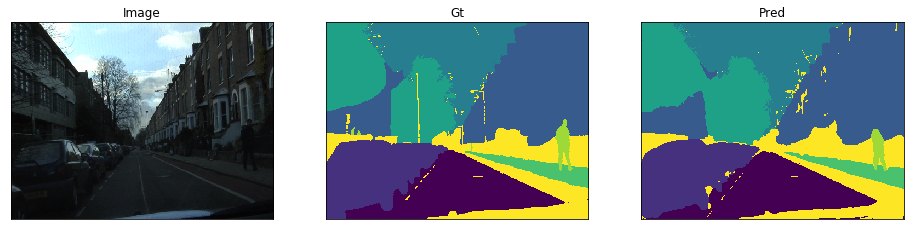

imageshape: torch.Size([3, 360, 480])


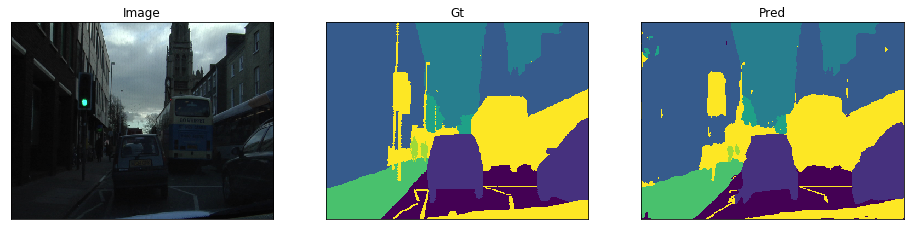

imageshape: torch.Size([3, 360, 480])


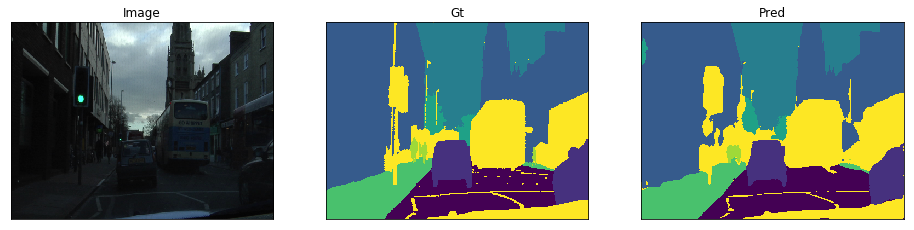

imageshape: torch.Size([3, 360, 480])


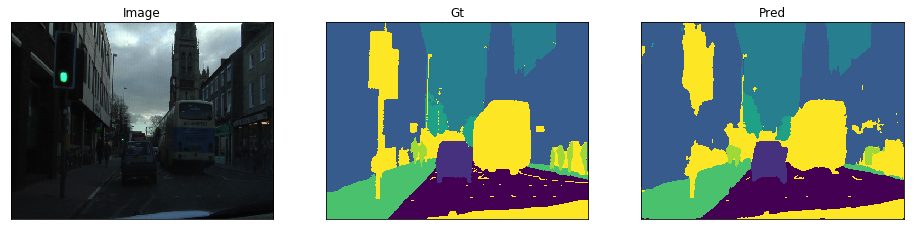

imageshape: torch.Size([3, 360, 480])


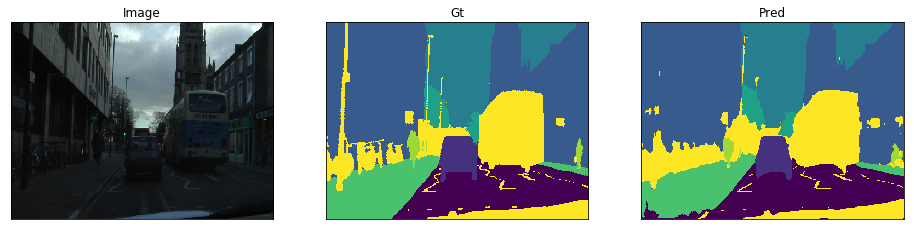

imageshape: torch.Size([3, 360, 480])


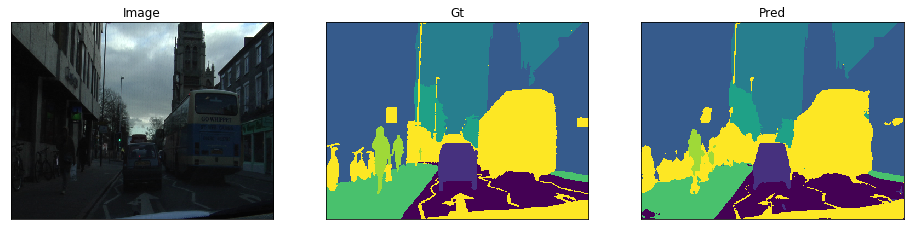

imageshape: torch.Size([3, 360, 480])


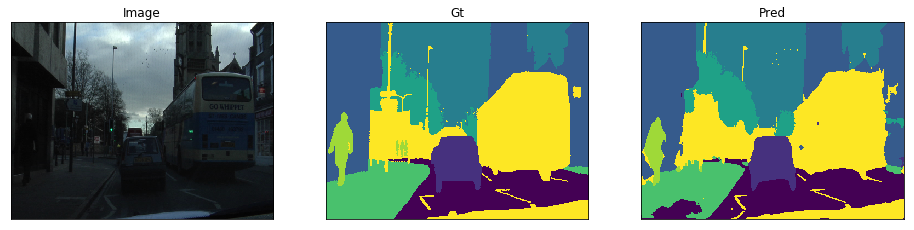

imageshape: torch.Size([3, 360, 480])


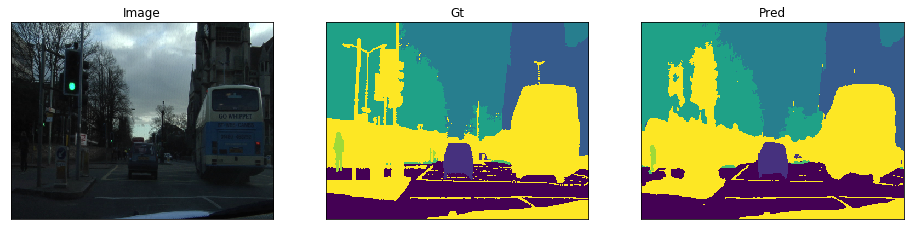

imageshape: torch.Size([3, 360, 480])


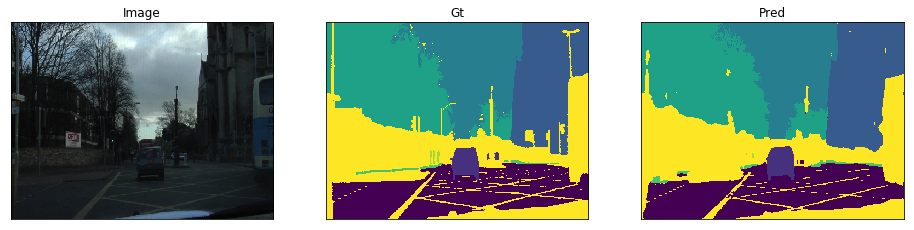

imageshape: torch.Size([3, 360, 480])


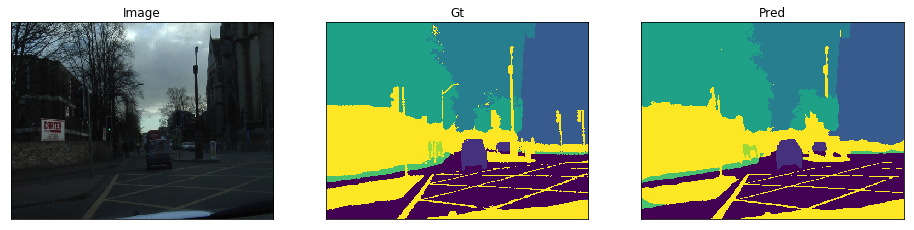

imageshape: torch.Size([3, 360, 480])


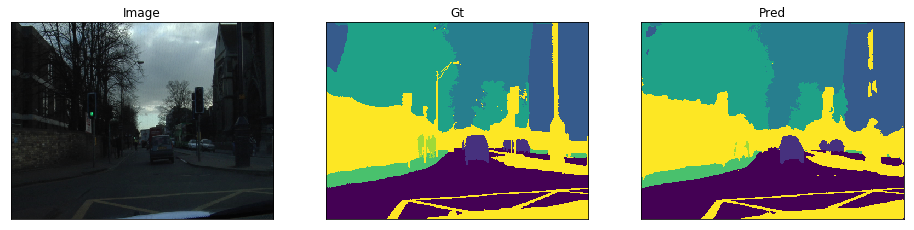

In [13]:
 # 测试
from torchvision import transforms
from PIL import Image
test_dataset = Dataset(
    x_train_dir, 
    y_train_dir,
    classes=CLASSES,
    augmentation=get_test_augmentation(),
    )
cnt = 0
# 选择设备，有cuda用cuda，没有就用cpu
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# 加载网络，图片单通道，分类为1。
net = UNet(n_channels=3, n_classes=n_classes)
#net = DFANet(cfg.ENCODER_CHANNEL_CFG,decoder_channel=64,n_classes=n_classes)
#net = load_backbone(net,"backbone.pth")
# 将网络拷贝到deivce中
net.to(device=device)
# 加载模型参数
print('load model')
net.load_state_dict(torch.load('valid_epoch-196-loss_valid-0.6953763737225197.pth', map_location=device))
print('done')
# 测试模式
print('model test')
net.eval()
print('done')

for num in range(len(test_dataset)):
    image, mask = test_dataset[num]
    show_image = image
    
    with torch.no_grad():
        image = image/255.
        image = image.astype('float32')
        image = torch.from_numpy(image)
        image = image.permute(2,0,1)
        image = image.to()
        print('imageshape:', image.shape)

        pred = net(image.unsqueeze(0).cuda())
        '''if net.n_classes > 1:
            pred = F.softmax(pred, dim=1)
            
        pred = pred.cpu()
        if net.n_classes > 1:
            pred = pred.permute(2, 3, 1, 0)'''
        mask = torch.from_numpy(mask)
        mask = torch.topk(mask, 1)[1].squeeze(1)
        mask = mask[..., 0].cpu()
        
        pred = pred.permute(2, 3, 1, 0)
        pred = torch.topk(pred[..., 0], 1)[1].squeeze(1)
        pred = pred[..., 0].cpu()
        #pred = pred.permute(2, 0, 1).cpu()
    #print(len(pred), len(pred[0]), len(pred[0, 0]))
    #print('pred:',pred.shape, pred)
    #print('mask:',mask.shape, mask)
    visualize(image=show_image,GT=mask,Pred=pred)
    cnt += 1
    if cnt > 10:
        break